# EAD
This notebook will train a model to predict Exposure at Default (EAD).

**LGD** indicates the possible lender may inccure if a debtor default.

Hence, like LGD model, it is a better practice to build the model with data that borrowers have a `charged off` status (status of loss)

From the data provided, we know that:

* `funded_amnt`: reflects the total amount that was lost at the moment the borrower defaulted;

* `total_rec_prncp`:  total principal received to date

Hence, the possible loss (EAD) can be measure by:

$EAD = funded\_amnt - total\_rec\_prncp$

In [2]:
import os
import sys

# Data Science
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import plotly.io as pio # plotly is only used if you have a powerfull machine
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

# machine learning
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

# pre-processing
from sklearn.preprocessing import StandardScaler

# save model
from joblib import dump

# hyper-parameter tuning
import optuna

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')


The procedure of EAD will be the same as LGD
First let's process the training data, and make target varaible

In [3]:
train_df = pd.read_csv('../data/train/train.csv')

DEFAULT_CATEGORIES = [
    "Charged Off",
    "Does not meet the credit policy. Status:Charged Off"
]

train_df = train_df[train_df["loan_status"].isin(DEFAULT_CATEGORIES)]

TARGET_VARIABLE = "EAD"

train_df[TARGET_VARIABLE] = (train_df["funded_amnt"] - train_df["total_rec_prncp"])
train_df[TARGET_VARIABLE].describe()

count    67068.000000
mean     11196.585659
std       7617.387018
min          0.000000
25%       5175.905000
50%       9749.155000
75%      15545.075000
max      40000.000000
Name: EAD, dtype: float64

The target variable distribution has a long tail, but it is still evenly distributed, so we don't need to use the zero-inflated model.

In [4]:
fig = ff.create_distplot([train_df[TARGET_VARIABLE]], [TARGET_VARIABLE], bin_size=1000)
fig.show()

In [5]:
SELECTED_FEATURES = [
    "id", "purpose", "initial_list_status", "emp_length",
    "pub_rec", "grade", "addr_state", "term",
    "int_rate", "EAD"
]
train_df = train_df[SELECTED_FEATURES]

encoded_df = pd.get_dummies(train_df['grade'], prefix='grade')
train_df = train_df.drop('grade', axis=1)
train_df = pd.concat([train_df, encoded_df], axis=1)

ADDR_STATE_MAP = {
    "ID": ["ID"],
    "NE_ME": ["NE","ME"],
    "ND": ["ND"],
    "MS_AR_OK": ["MS", "OK", "AR"],
    "SD_LA_AL_AK_IN": ["SD", "LA", "AL", "AK", "IN"],
    "WV_MO_MD_OH": ["WV", "MO", "MD", "OH"],
    "NY_TN_KY_NJ_SC_NC_CT": ["NY", "TN", "KY", "NJ", "SC", "NC", "CT"],
    "IL": ["IL"],
    "PA_NM": ["PA", "NM"],
    "TX_VT": ["TX", "VT"],
    "FL_NV_GA": ["FL", "NV", "GA"],
    "VA_MN": ["MN", "VA"],
    "KS_DE_MA_MI_MT": ["KS", "DE", "MA", "MI", "MT"],
    "AZ_HI_WY_WI": ["AZ", "HI", "WY", "WI"],
    "RI_CA_NH": ["RI", "CA", "NH"],
    "WA_CO_OR_UT": ["WA", "CO", "OR", "UT"],
    "DC": ["DC"]
}

reverse_map = {state: group for group, states in ADDR_STATE_MAP.items() for state in states}

train_df["addr_state"] = train_df["addr_state"].map(reverse_map)

encoded_df = pd.get_dummies(train_df["addr_state"], prefix="addr_state")
train_df = train_df.drop("addr_state", axis=1)
train_df = pd.concat([train_df, encoded_df], axis=1)

PURPOSES_MAP = {
    "cred_card": ["credit_card"],
    "vacation": ["vacation"],
    "car": ["car"],
    "home_improv_debt_consol": ["home_improvement", "debt_consolidation"],
    "moving": ["moving"],
    "renewable_energy": ["renewable_energy"],
    "major_purchase_medical": ["major_purchase", "medical"],
    "other": ["other"],
    "wedding": ["wedding"],
    "small_business": ["small_business"],
    "house": ["house"]
}

reverse_map = {purpose: group for group, purposes in PURPOSES_MAP.items() for purpose in purposes}
train_df["purpose"] = train_df["purpose"].map(reverse_map)

encoded_df = pd.get_dummies(train_df["purpose"], prefix="purpose")
train_df = train_df.drop("purpose", axis=1)
train_df = pd.concat([train_df, encoded_df], axis=1)

encoded_df = pd.get_dummies(train_df["initial_list_status"], prefix="initial_list_status")
train_df = train_df.drop("initial_list_status", axis=1)
train_df = pd.concat([train_df, encoded_df], axis=1)


EMP_LENGTH_MAP = {
    "0": 0,
    "< 1 year": 1,
    "1 year": 1,
    "2 years": 2,
    "3 years": 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}
train_df["emp_length"] = train_df["emp_length"].map(EMP_LENGTH_MAP)

TERM_MAP = {
    " 36 months": 36.0,
    " 60 months": 60.0,
}
train_df["term"] = train_df["term"].map(TERM_MAP)

### Categorical Features

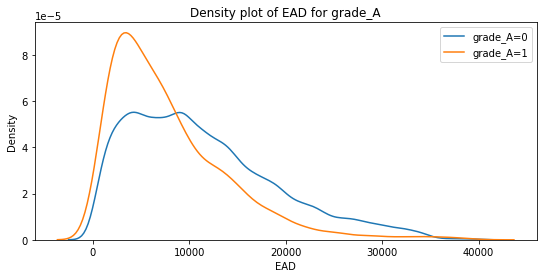

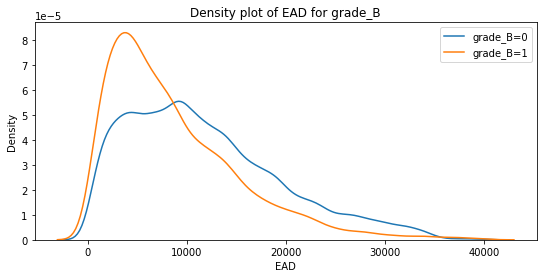

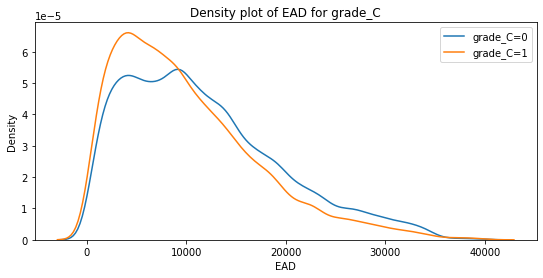

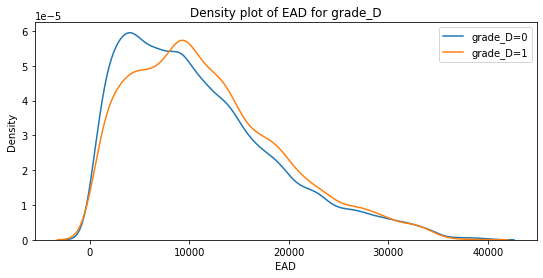

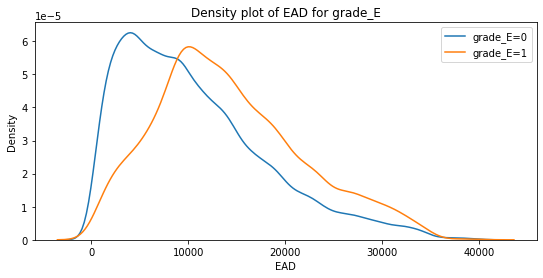

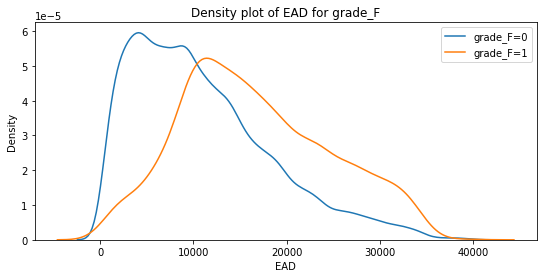

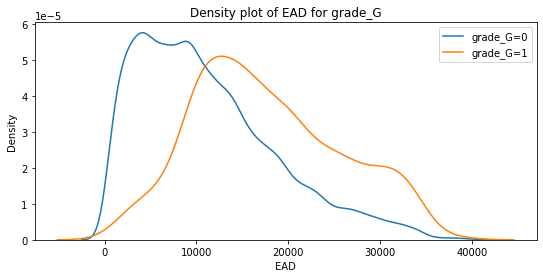

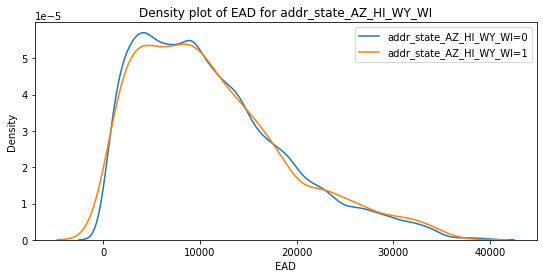

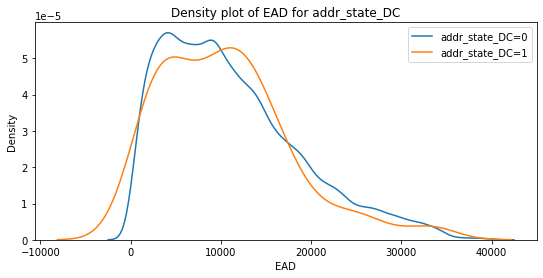

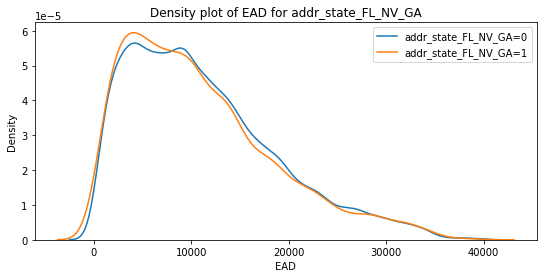

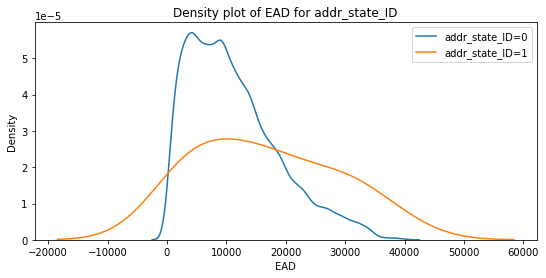

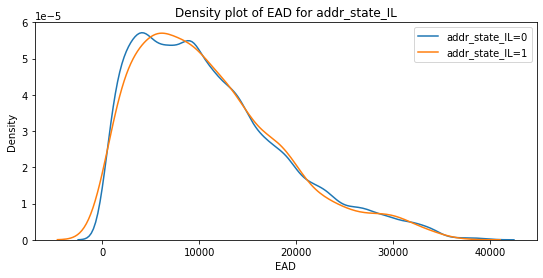

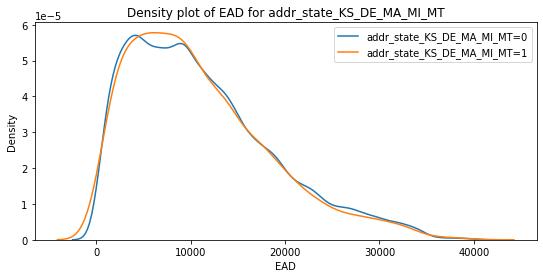

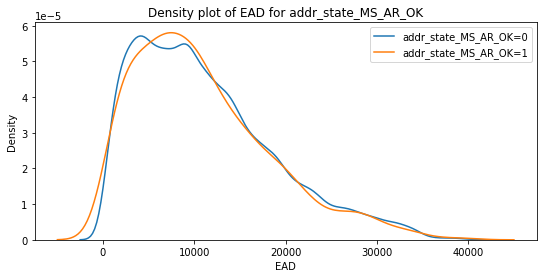

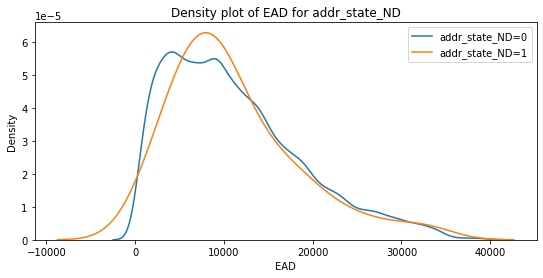

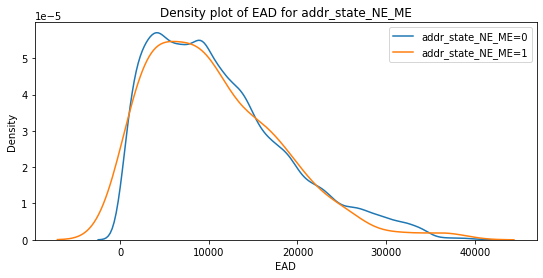

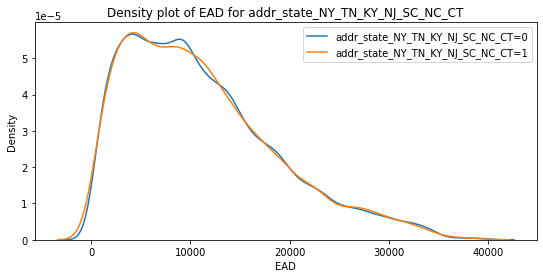

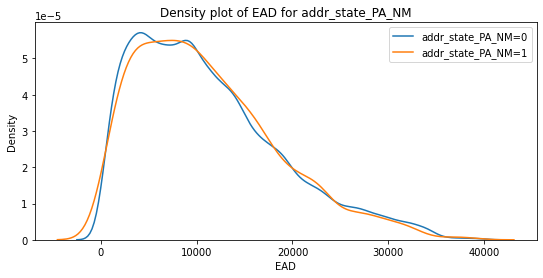

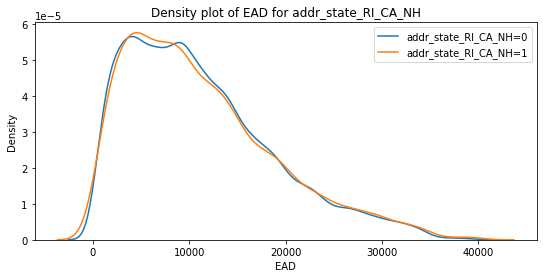

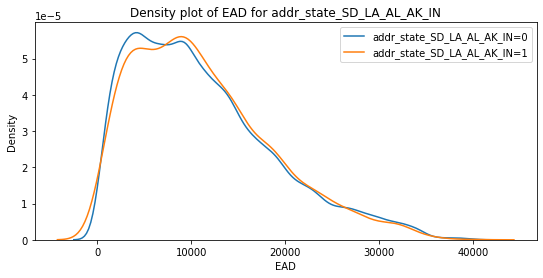

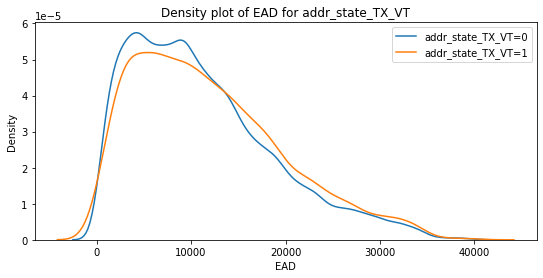

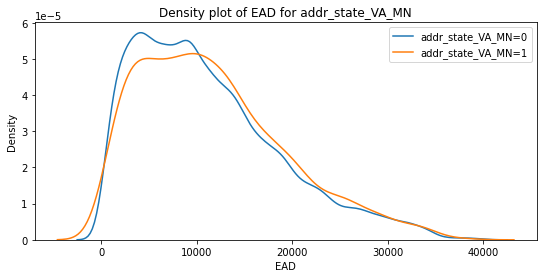

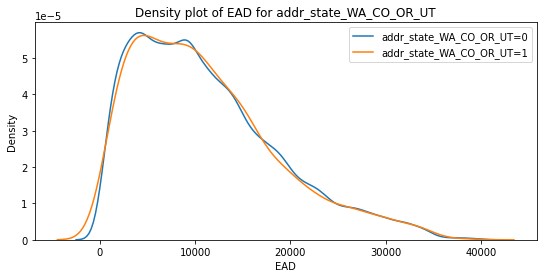

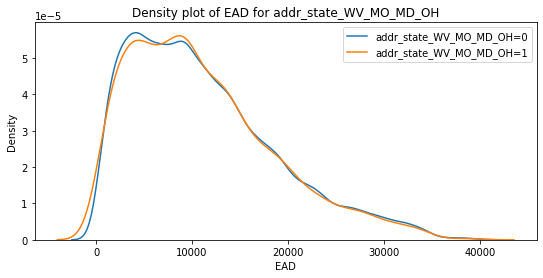

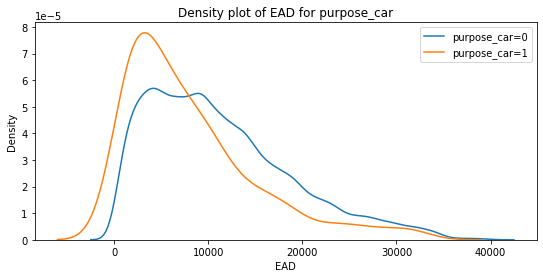

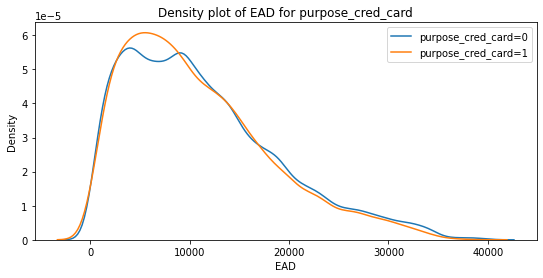

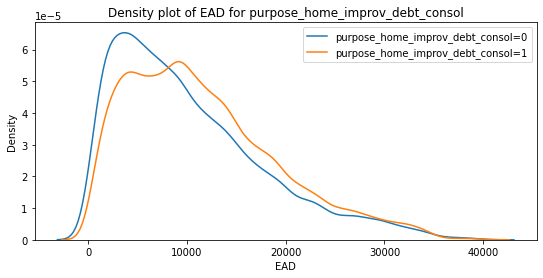

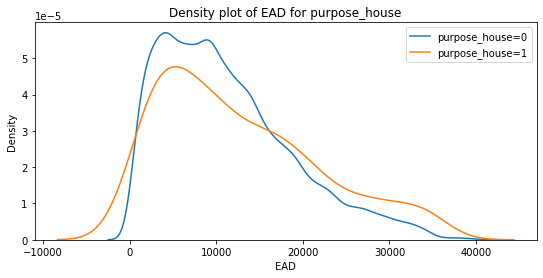

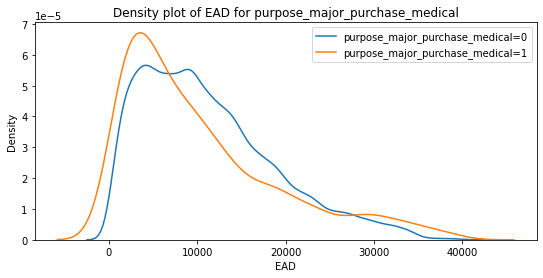

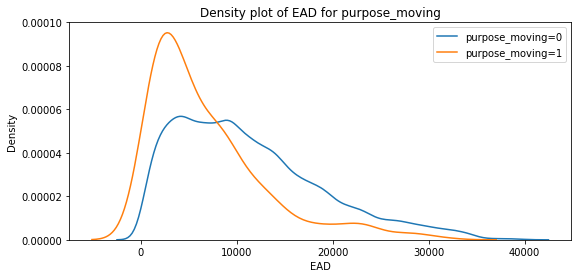

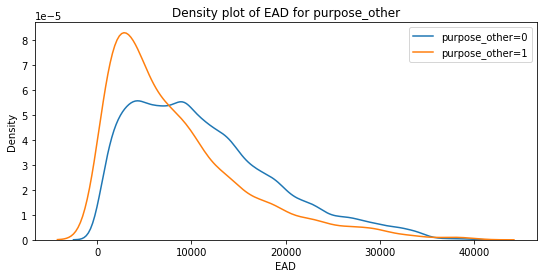

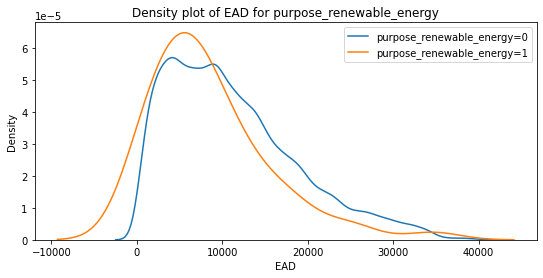

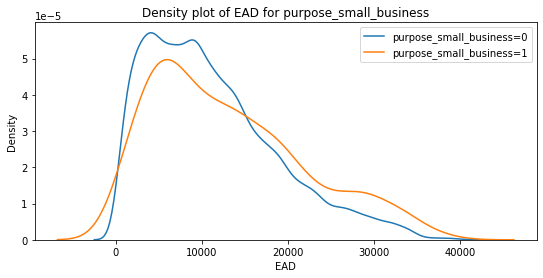

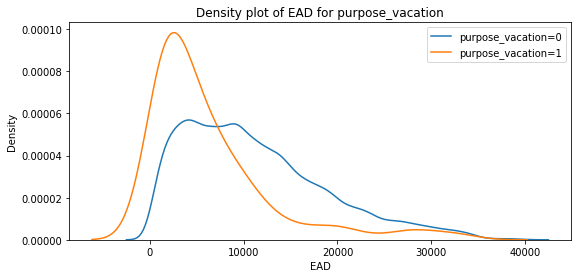

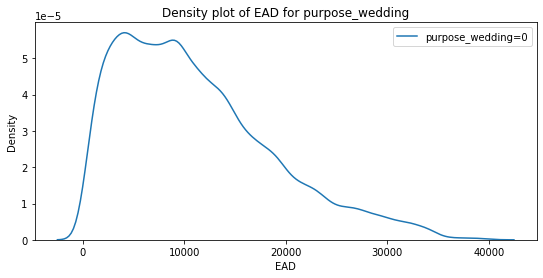

In [6]:
DUMMIES_PREFIX = ["grade", "addr_state", "purpose"]
for prefix in DUMMIES_PREFIX:
    dummy_cols = [col for col in train_df.columns if col.startswith(prefix)]
    
    for col in dummy_cols:

        group0 = train_df[train_df[col] == 0][TARGET_VARIABLE]
        group1 = train_df[train_df[col] == 1][TARGET_VARIABLE]

        plt.figure(figsize=(9, 4)) 
        sns.kdeplot(group0, label=f'{col}=0')
        sns.kdeplot(group1, label=f'{col}=1')
        plt.legend()
        plt.title(f'Density plot of {TARGET_VARIABLE} for {col}')
        plt.show()

We can see that there is not value for purpose_wedding. It can be explained because the value "wedding" in "purpose" features have no charged off value. I one-hot encoded the feature by the map from PD model. Hence we need to remove the 'purpose wedding features'

In [7]:
train_df = train_df.drop('purpose_wedding', axis=1)

### Numerical Features

<AxesSubplot:>

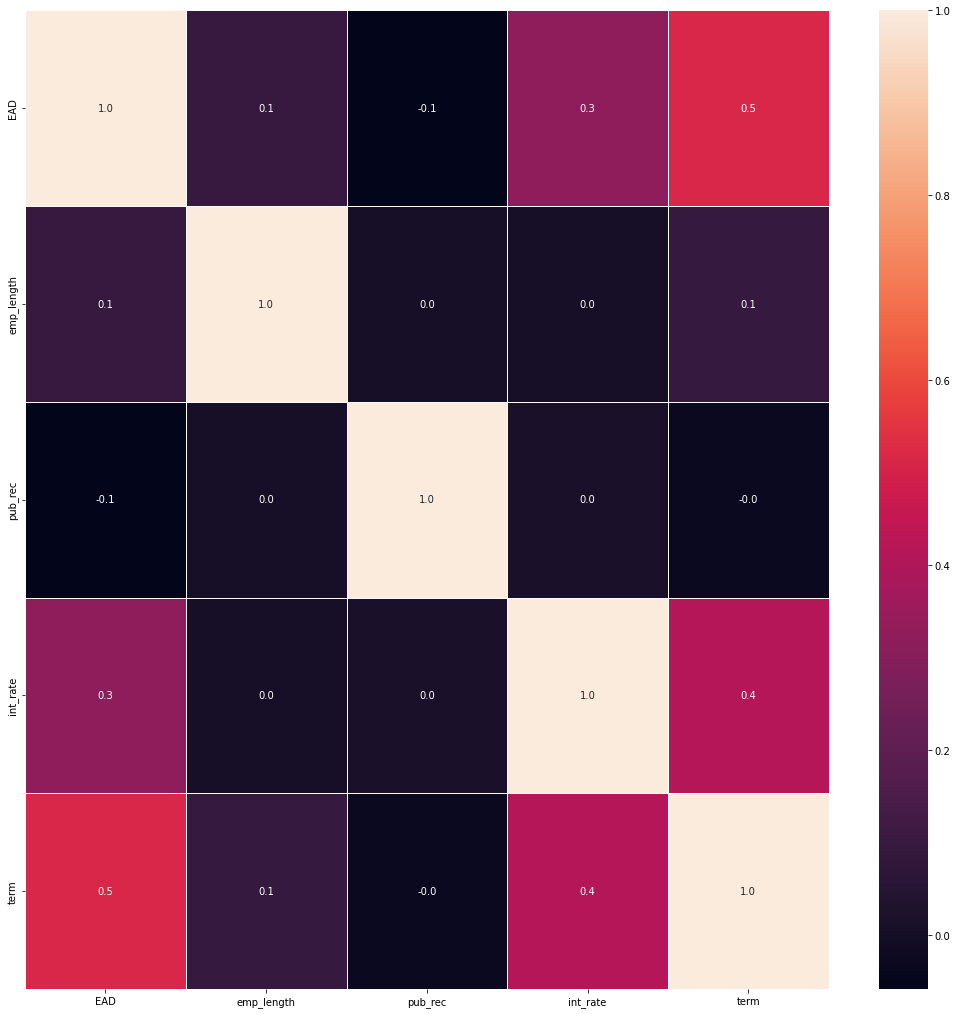

In [8]:
NUMERICAL_FEATURES = ['EAD', 'emp_length', 'pub_rec', 'int_rate', 'term']
fig,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(train_df[NUMERICAL_FEATURES].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)


## Model Training

In [9]:
y_train = train_df[TARGET_VARIABLE]
X_train = train_df.drop(TARGET_VARIABLE, axis=1)
X_train = X_train.drop('id', axis=1)
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [10]:
dump(scaler, '../models/scalers/EAD_scaler.joblib')

['../models/scalers/EAD_scaler.joblib']

In [7]:
def objective(trial):
    params = {
        'regressor__n_estimators': trial.suggest_int('regressor__n_estimators', 100, 500),
        'regressor__max_depth': trial.suggest_int('regressor__max_depth', 3, 10),
        'regressor__learning_rate': trial.suggest_loguniform('regressor__learning_rate', 0.005, 0.5),
        'regressor__min_child_weight': trial.suggest_int('regressor__min_child_weight', 1, 10),
        'regressor__subsample': trial.suggest_discrete_uniform('regressor__subsample', 0.5, 0.9, 0.1),
        'regressor__colsample_bytree': trial.suggest_discrete_uniform('regressor__colsample_bytree', 0.5, 0.9, 0.1),
        'regressor__objective': trial.suggest_categorical('regressor__objective', ['reg:squarederror']),
    }
    

    regressor_obj=XGBRegressor(
        n_estimators=params['regressor__n_estimators'],
        max_depth=params['regressor__max_depth'],
        learning_rate=params['regressor__learning_rate'],
        min_child_weight=params['regressor__min_child_weight'],
        subsample=params['regressor__subsample'],
        colsample_bytree=params['regressor__colsample_bytree'],
        objective=params['regressor__objective']
    )
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj,  X_train, y_train, cv=kfold, scoring='r2')  # change scoring as needed
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print(best_params)

[I 2023-05-16 02:20:43,552] A new study created in memory with name: no-name-d32d120a-75c6-4c67-b2a5-6908dbbe87aa
[I 2023-05-16 02:21:04,310] Trial 0 finished with value: 0.29906337201416816 and parameters: {'classifier__objective': 'binary:logistic', 'regressor__n_estimators': 428, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.006822881725141533, 'regressor__min_child_weight': 4, 'regressor__subsample': 0.9, 'regressor__colsample_bytree': 0.5, 'regressor__objective': 'reg:squarederror'}. Best is trial 0 with value: 0.29906337201416816.
[I 2023-05-16 02:21:37,414] Trial 1 finished with value: 0.2960055514265513 and parameters: {'classifier__objective': 'binary:logistic', 'regressor__n_estimators': 492, 'regressor__max_depth': 9, 'regressor__learning_rate': 0.0693807383459656, 'regressor__min_child_weight': 5, 'regressor__subsample': 0.7, 'regressor__colsample_bytree': 0.6, 'regressor__objective': 'reg:squarederror'}. Best is trial 0 with value: 0.29906337201416816.
[I 2023-0

{'classifier__objective': 'binary:logistic', 'regressor__n_estimators': 427, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.08441802696509675, 'regressor__min_child_weight': 6, 'regressor__subsample': 0.7, 'regressor__colsample_bytree': 0.7, 'regressor__objective': 'reg:squarederror'}


In [12]:
model = XGBRegressor(
        n_estimators=427,
        max_depth=4,
        learning_rate=0.08441802696509675,
        min_child_weight=6,
        subsample=0.7,
        colsample_bytree=0.7,
        objective='reg:squarederror'
    )

model.fit(X_train, y_train)

dump(model, '../models/EAD_model.joblib')

['../models/EAD_model.joblib']